In [ ]:
import os, gc, warnings, pickle, psutil, \
        random, psutil, datetime, math, time
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings('ignore')

# Exploratory data analysis


&emsp; The first step to analyzing the problem is understanding the situation, complication, and key question. Before beginning the modeling process, the data needs some processing as the data fed into the algorithm is important to ensure an accurate result.

&emsp; For that reason, in the steps described in the section below, we perform data transformations and feature engineering to extract the relevant features with strong predicting power. Next, we dealt with outliers, as there were many outliers in the datasets. Finally, we utilized two different models to generate final predictions, a LightGBM and an XGBoost, and ensembled them using a neural network as a metamodel.


In [ ]:
calendar = pd.read_csv('calendar.csv')
selling_prices = pd.read_csv('sell_prices.csv')
sales_train_val = pd.read_csv('sales_train_validation.csv')

In [ ]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


Overall view of the data: The original data is at the product level and the data lists the sales of each product in a duration of 1914 days.

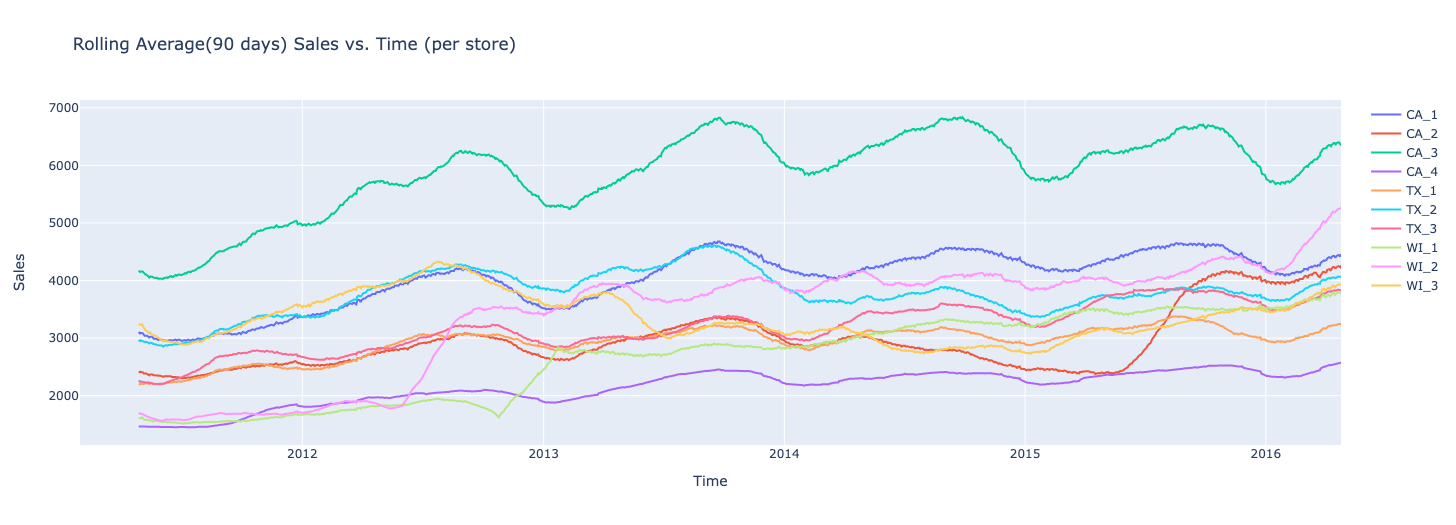

In [1]:
Image('/content/newplot1.png',width=950, height=500)

There are so many products that we can get access to the tracking of the sales, to get the trend of the sales, the data is aggregated to the store level. The line chart of the rolling avenue (90 days) of each store (up to 10 stores) is plotted out.

From the overall plot, we can see that there is a linear growth trend in the long term. Also, it is seasonality for all of the shops. So that we decided to use the month level data.

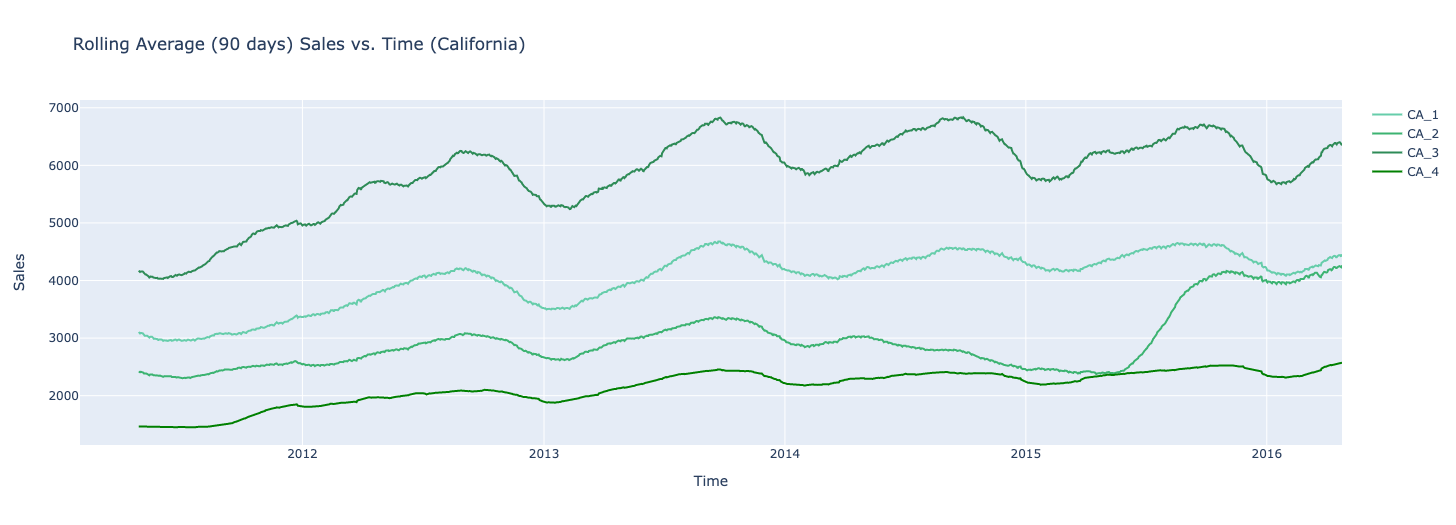

In [11]:
Image('/content/newplot2.png',width=1000, height=500)

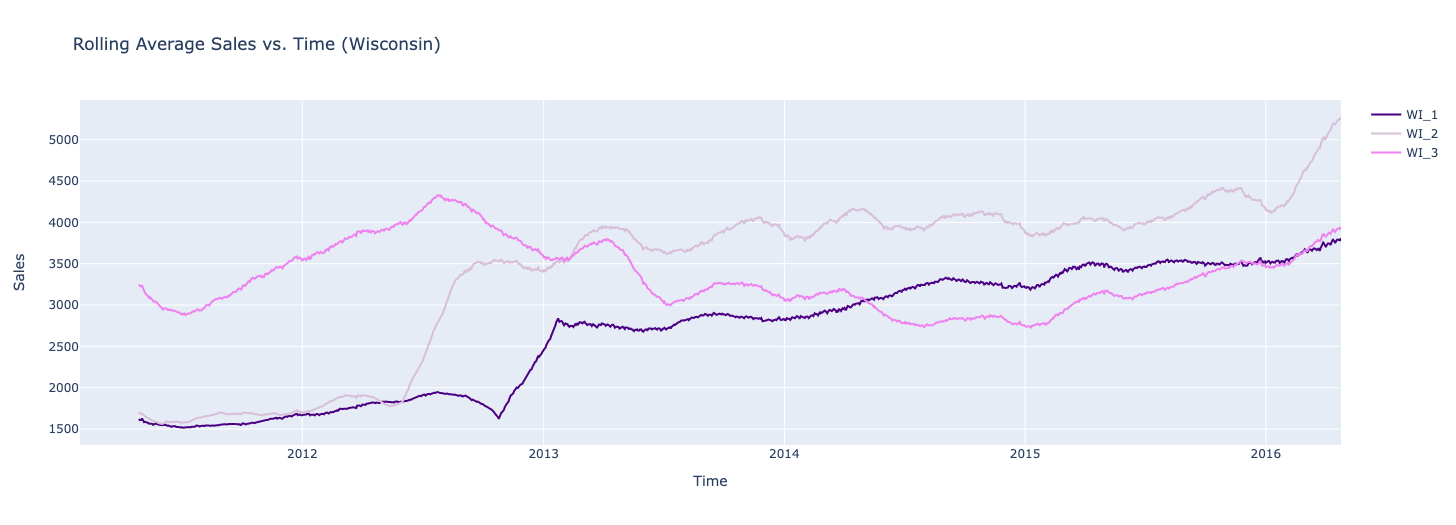

In [9]:
Image('/content/newplot3.png',width=1000, height=500)

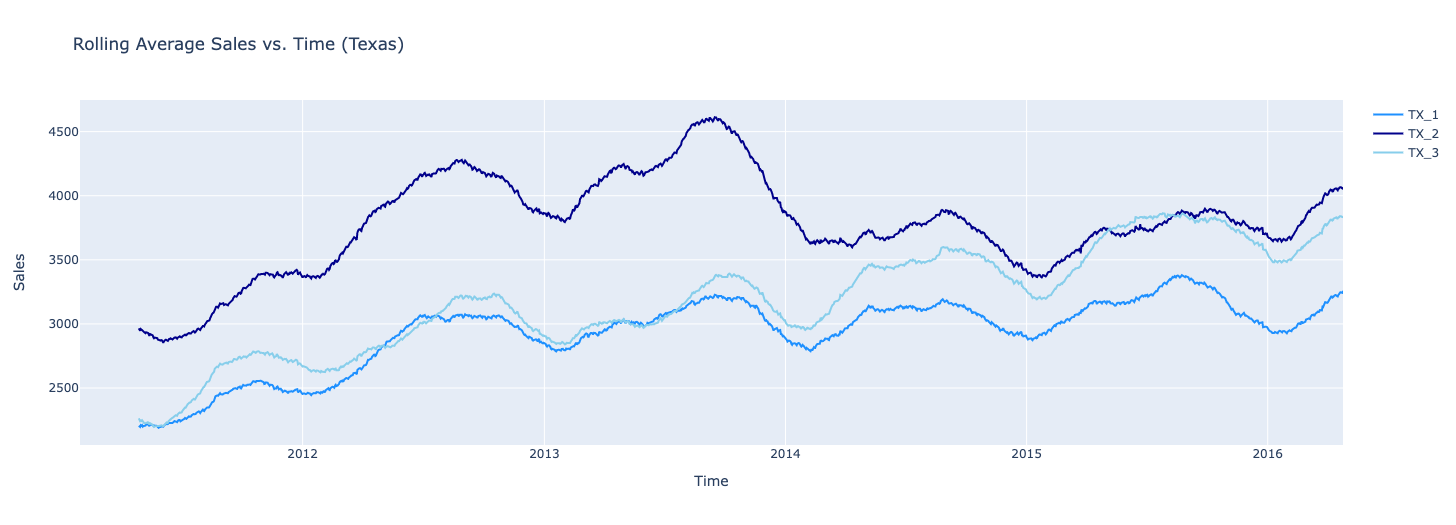

In [10]:
Image('/content/newplot4.png',width=1000, height=500)

The plots of sales for each store in each state are plotted out. According to the plot, the trend and pattern for each store are different from each other even in the same state. For example, there is a sudden decrease at WI_3 while there is a trend of increase at WI_1 and WI_2.

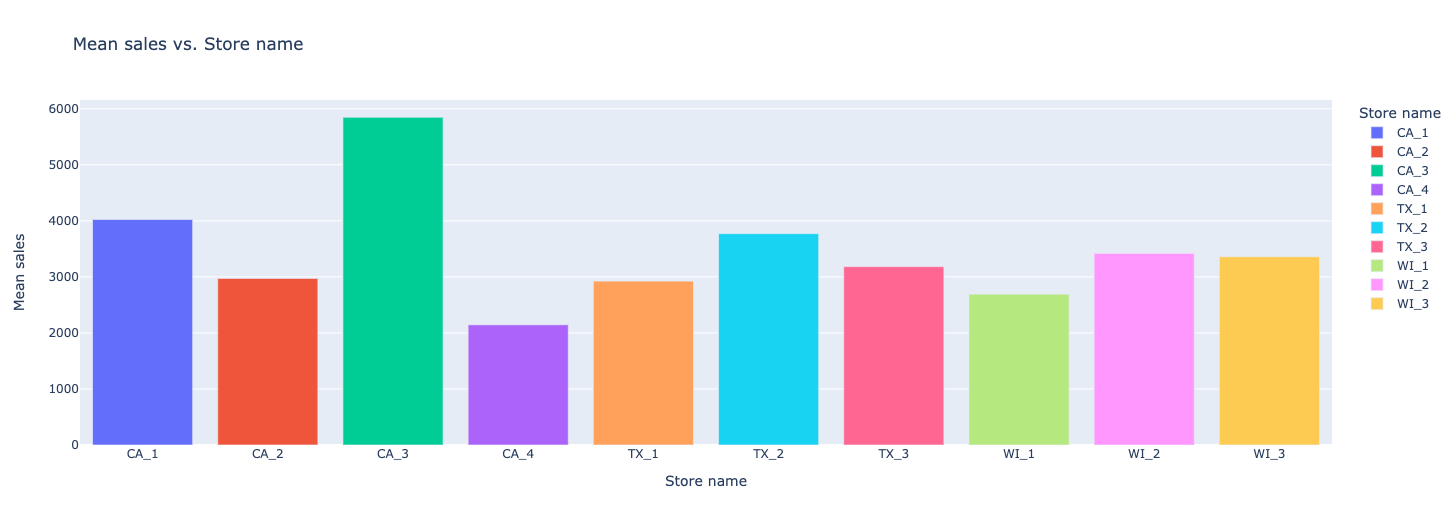

In [8]:
Image('/content/newplot5.png',width=1000, height=500)

According to the mean sales calculations for each store, we can see the mean sales of CA_3 is the highest while the CA_4 is the lowest from the chart. The mean sales of stores in Texas and Wisconsin are similar in the same state while the mean sales differ a lot from store to store in California.

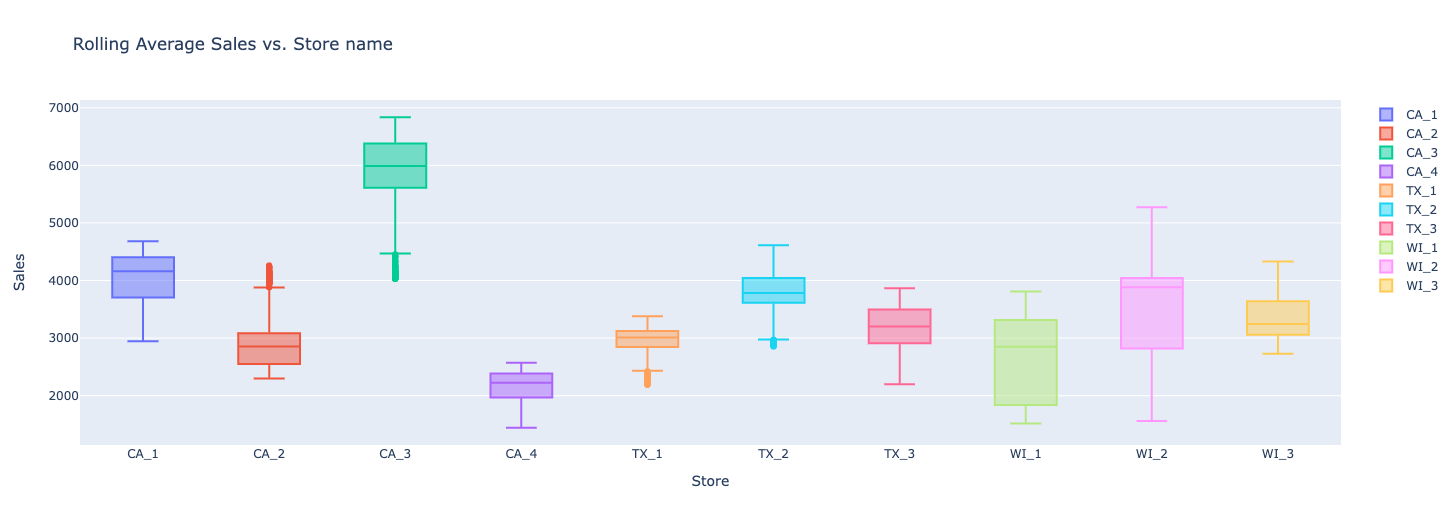

In [12]:
Image('/content/newplot6.png',width=1000, height=500)

The variance of the sales of different products in different stores. the variance in Wisconsin is large and it in Texas is small, which means the sales of different products differ a lot in Wisconsin while the sales of different products are close to each other in Texas.

Due to the differences in different stores, we are going to use the store level data instead of the state level.

# Predictive Model

## Data Preparation and Feature Engineering

### Basic parameter setup

In [ ]:
# Path for raw files
SALES_PATH = "sales_train_evaluation.csv"
CALENDAR_PATH = 'calendar.csv'
PRICES_PATH = "sell_prices.csv"

# Parameters that we will use for training and prediction
TARGET = 'sales'                 # Our target
MAIN_INDEX = ['id','d']          # We can identify item by these columns
PREDICTION_HORIZON_LIST = [7,14,21,28]
PREDICTION_LENGTH  = 28         
STORES_IDS = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN = 1941                 # End day of our train set
SEED = 42                        # We want all things to be deterministic        

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

# FEATURES to remove
REMOVE_FEATURES = ['id','state_id','store_id',
                   'date','wm_yr_wk','d','sales']

MEAN_FEATURES   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

### Helper functions

In [ ]:
# get current memory usuage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

# merge two datafram without changing dtype
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    
    return df1


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

### Functions to generate features

In [ ]:
def global_stat(df_path):
    grid_df = pd.read_pickle(df_path)
    base_cols = list(grid_df)

    icols =  [
        ['state_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id'],
        ]

    for col in icols:
        col_name = '_'+'_'.join(col)+'_'
        grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)['sales'].transform('mean').astype(np.float16)
        grid_df['enc'+col_name+'std'] = grid_df.groupby(col)['sales'].transform('std').astype(np.float16)

    keep_cols = [col for col in list(grid_df) if col not in base_cols]
    grid_df = grid_df[['id','d']+keep_cols]
    
    return grid_df


def lag(df_path, target_val='sales', lag_range=range(1,15)):
    grid_df = pd.read_pickle(df_path)

    # We need only 'id','d','sales'
    # to make lags and rollings
    grid_df = grid_df[['id','d','sales']]

    # Lags
    # with 28 day shift
    grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(target_val, lag): grid_df.groupby(['id'])[target_val].transform(lambda x: x.shift(lag))
        for lag in lag_range
    })

    # Minify lag columns
    for col in list(grid_df):
        if 'lag' in col:
            grid_df[col] = grid_df[col].astype(np.float16)

    grid_df = grid_df.drop(columns=['sales'])
    
    return grid_df


def rolling(df_path, target_val='sales', shift_range=[7, 14, 21, 28]):
    grid_df = pd.read_pickle(df_path)

    # We need only 'id','d','sales'
    # to make lags and rollings
    grid_df = grid_df[['id','d','sales']]

    # Rollings
    # with sliding shift
    for d_shift in shift_range: 
        for d_window in [7,14,30,60, 180]:
            col_name = 'rolling_mean_'+str(d_shift)+'_'+str(d_window)
            grid_df[col_name] = grid_df.groupby(['id'])[target_val].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
            col_name = 'rolling_std_'+str(d_shift)+'_'+str(d_window)
            grid_df[col_name] = grid_df.groupby(['id'])[target_val].transform(lambda x: x.shift(d_shift).rolling(d_window).std()).astype(np.float16)

    grid_df = grid_df.drop(columns=['sales'])
    return grid_df

In [ ]:
def create_df_by_store(path, prefix=""):
    df = pd.read_csv(path)
    stores = df.store_id.unique()
    for store in stores:
        temp = df[df.store_id == store]
        temp.to_csv(prefix + store + '.csv')


def create_dataset(sales_path, cal_path, prices_path, end_train, pred_size=28):
    END_TRAIN = end_train         
    END_TEST = END_TRAIN + pred_size + 1

    numcols = [f"d_{day}" for day in range(1, 1942)]
    usecols = [f"d_{day}" for day in range(1, END_TEST)]
    testcols = [f"d_{day}" for day in range(END_TRAIN + 1, END_TEST)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})

    train_df = pd.read_csv(sales_path, usecols = catcols + numcols, dtype = dtype)                    
    for col in catcols:
        if col != "id":
            train_df[col] = train_df[col].cat.codes.astype("int16")
            train_df[col] -= train_df[col].min()

    #read sell_prices.csv
    prices_df = pd.read_csv(prices_path, dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices_df[col] = prices_df[col].cat.codes.astype("int16")
            prices_df[col] -= prices_df[col].min()

    #turn into long format
    index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
    grid_df = pd.melt(train_df, 
                    id_vars = index_columns, 
                    var_name = 'd', 
                    value_name = TARGET)

    grid_df = grid_df[grid_df.d.isin(usecols)]

    #read calendar.csv
    calendar_df = pd.read_csv(cal_path, dtype = CAL_DTYPES)
    calendar_df["date"] = pd.to_datetime(calendar_df["date"])
    calendar_df["ytd_event_name"] = calendar_df.event_name_1.shift(1)
    calendar_df["ytd_event_type"] = calendar_df.event_type_1.shift(1)

    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            calendar_df[col] = calendar_df[col].cat.codes.astype("int16")
            calendar_df[col] -= calendar_df[col].min()

    add_grid = pd.DataFrame()
    for i in range(1,29):
        temp_df = train_df[index_columns]
        temp_df = temp_df.drop_duplicates()
        temp_df['d'] = 'd_'+ str(END_TRAIN+i)
        temp_df[TARGET] = np.nan
        add_grid = pd.concat([add_grid,temp_df])

    # Remove all the test rows from grid_df
    # Save all the test_row to test_df
    test_df = grid_df[grid_df.d.isin(testcols)].copy()
    grid_df = grid_df[~grid_df.d.isin(testcols)]

    grid_df = pd.concat([grid_df,add_grid])
    grid_df = grid_df.reset_index(drop=True)

    # Remove some temoprary DFs
    del temp_df, add_grid
    del train_df

    #reduce memory usage
    for col in index_columns:
        grid_df[col] = grid_df[col].astype('category')
        
    grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)
    calendar_df['d'] = calendar_df['d'].apply(lambda x: x[2:]).astype(np.int16)

    prices_df = reduce_mem_usage(prices_df, verbose=False)
    grid_df = reduce_mem_usage(grid_df, verbose=False)
    calendar_df = reduce_mem_usage(calendar_df, verbose=False)
    
    grid_df.memory_usage()

    release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
    release_df.columns = ['store_id','item_id','release']

    # Now we can merge release_df
    grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
    del release_df

    # Merge calendar
    grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])

    # Now we can cutoff row that is before release week to safe memory 
    ####################################
    ##### RNN may not have to drop #####
    ####################################
    grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
    grid_df = grid_df.reset_index(drop=True)

    # Change value of the column release to be the week of release
    grid_df['release'] = grid_df['release'] - grid_df['release'].min()
    grid_df['release'] = grid_df['release'].astype(np.int16)

    grid_df.to_pickle('grid_part_1.pkl')

    # create price related features
    # We can do some basic aggregations
    prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
    prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
    prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
    prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

    # and do price normalization (min/max scaling)
    prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

    # Some items are can be inflation dependent
    # and some items are very "stable"
    prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
    prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

    # I would like some "rolling" aggregations
    # but would like months and years as "window"
    calendar_prices = calendar_df[['wm_yr_wk','month','year']]
    calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])

    prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
    del calendar_prices

    prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
    prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
    prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

    prices_df['sell_price_cent'] = [math.modf(p)[0] for p in prices_df['sell_price']]
    prices_df['price_max_cent'] = [math.modf(p)[0] for p in prices_df['price_max']]
    prices_df['price_min_cent'] = [math.modf(p)[0] for p in prices_df['price_min']]
    del prices_df['month'], prices_df['year']
    prices_df = reduce_mem_usage(prices_df, verbose=False)

    # Merge Prices
    original_columns = list(grid_df)
    grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
    keep_columns = [col for col in list(grid_df) if col not in original_columns]

    grid_df = grid_df[MAIN_INDEX+keep_columns]
    grid_df = reduce_mem_usage(grid_df, verbose=False)

    grid_df.to_pickle('grid_part_2.pkl')

    grid_df = grid_df[MAIN_INDEX]

    # Merge calendar partly
    icols = ['date',
            'd',
            'event_name_1',
            'event_type_1',
            'event_name_2',
            'event_type_2',
            'ytd_event_name',
            'ytd_event_type',
            'snap_CA',
            'snap_TX',
            'snap_WI']

    grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

    # Minify data
    # 'snap_' columns we can convert to bool or int8
    icols = ['event_name_1',
            'event_type_1',
            'event_name_2',
            'event_type_2',
            'snap_CA',
            'snap_TX',
            'snap_WI']
    for col in icols:
        grid_df[col] = grid_df[col].astype('category')

    # Make some features from date
    grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)    #   
    grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
    grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
    grid_df['tm_y'] = grid_df['date'].dt.year
    grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
    grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: math.ceil(x/7)).astype(np.int8)
    grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
    grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

    # Remove date
    del grid_df['date']

    #save part 3
    grid_df.to_pickle('grid_part_3.pkl')

    # delete unused dataframe
    del calendar_df
    del grid_df

    # Calculate lags and rolling dataframe
    print('Calculating lag columns ...')
    lag_df = lag('grid_part_1.pkl', target_val='sales', lag_range=range(7, 50))
    print('Calculating rolling columns ...')
    rol_df = rolling('grid_part_1.pkl', target_val='sales')
    print('calculating global statistics ...')
    global_stat_df = global_stat('grid_part_1.pkl')

    sales = pd.read_pickle('grid_part_1.pkl')
    price_df = pd.read_pickle('grid_part_2.pkl')
    cal_df = pd.read_pickle('grid_part_3.pkl')

    print('Combining all dataframes ...')
    combined_df = sales.merge(price_df, how='left', on=['id', 'd']) \
        .merge(cal_df, how='left', on=['id', 'd']) \
        .merge(lag_df, how='left', on=['id', 'd']) \
        .merge(rol_df, how='left', on=['id', 'd']) \
        .merge(global_stat_df, how='left', on=['id', 'd'])

    combined_df = combined_df.drop(columns=['store_id'])
    test_df = test_df.drop(columns=['store_id'])
    return combined_df, test_df

### Data Preparation

Now, Let's utilize all the functions we created above to generate the target dataset by store

In [ ]:
# Create a csv file for each store
create_df_by_store('sales_train_evaluation.csv')

In [ ]:
sales = pd.read_csv(SALES_PATH)
all_stores = sales.store_id.unique()
for store in all_stores:
    name = f'{store}_processed'
    print(f'Creating {name}')
    store_sales_path = store + '.csv'
    train, test = create_dataset(store_sales_path, CALENDAR_PATH, PRICES_PATH, end_train=END_TRAIN, pred_size=PREDICTION_LENGTH)
    print(f'Saving {name}')
    train.to_pickle(f'{name}.pkl')
    if test.shape[0] != 0:
        test.to_pickle(f'{name}_gt.pkl')

Creating CA_1_processed
Calculating lag columns ...
Calculating rolling columns ...
calculating global statistics ...
Combining all dataframes ...
Saving CA_1_processed
Creating CA_2_processed
Calculating lag columns ...
Calculating rolling columns ...
calculating global statistics ...
Combining all dataframes ...
Saving CA_2_processed
Creating CA_3_processed
Calculating lag columns ...
Calculating rolling columns ...
calculating global statistics ...
Combining all dataframes ...
Saving CA_3_processed
Creating CA_4_processed
Calculating lag columns ...
Calculating rolling columns ...
calculating global statistics ...
Combining all dataframes ...
Saving CA_4_processed
Creating TX_1_processed
Calculating lag columns ...
Calculating rolling columns ...
calculating global statistics ...
Combining all dataframes ...
Saving TX_1_processed
Creating TX_2_processed
Calculating lag columns ...
Calculating rolling columns ...
calculating global statistics ...
Combining all dataframes ...
Saving T

## Model Training and Validation

In [ ]:
def filter_cols(df, prediction_horizon):
    """
    Return the filter dataframe which only include the related features based on the prediction_horizon
    """
    target_cols = []
    
    for col in df.columns:
        if col[:9] == 'sales_lag':
            lag_number = int(col.split('_')[-1])
            if lag_number >= prediction_horizon and lag_number < prediction_horizon + 14:
                target_cols.append(col)
        elif col[:3] == 'rol':
            rol_number = int(col.split('_')[-2])
            if rol_number == prediction_horizon:
                target_cols.append(col)
        else:
            target_cols.append(col)
            
    return df[target_cols]


def get_data_by_store(store, start_train, prediction_horizon):
    df = pd.read_pickle(f'{store}_processed.pkl')
    
    # Filter out the unwanted columns that don't belong to prediction_horizon
    df = filter_cols(df, 7)

    enable_features = [col for col in list(df) if col not in REMOVE_FEATURES]
    df = df[['id','d','sales'] + enable_features]
    
    # Skipping first n rows
    df = df[df['d'] >= start_train].reset_index(drop=True)
    
    return df, enable_features 


def train(store_id_set_list, start_train, prediction_horizon):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'tweedie_variance_power': 1.1,
        'metric': 'rmse',
        'subsample': 0.5,
        'subsample_freq': 1,
        'learning_rate': 0.03,
        'num_leaves': 2 ** 11 - 1,
        'min_data_in_leaf': 2 ** 12 - 1,
        'feature_fraction': 0.5,
        'n_estimators': 1400,
        'boost_from_average': False,
        'verbose': -1,
    }
                       
    lgb_params['seed'] = seed_everything(SEED)

    # Empty dataframe to store feature importance values
    feature_importance_all_df = pd.DataFrame()

    for store_id in store_id_set_list:

        grid_df, enable_features = get_data_by_store(store_id, start_train, prediction_horizon)

        train_mask = grid_df['d'] <= END_TRAIN                                           
        valid_mask = grid_df['d'].between((END_TRAIN - prediction_horizon), END_TRAIN, inclusive='right')  #1904 - 1913 if prediction_horizon == 7  
        preds_mask = grid_df['d'] > (END_TRAIN - 100) #1813 -1941  # Test (All data greater than 1913 day, with some gap for recursive features)   

        train_data = lgb.Dataset(grid_df[train_mask][enable_features], label=grid_df[train_mask]['sales'])
        valid_data = lgb.Dataset(grid_df[valid_mask][enable_features], label=grid_df[valid_mask]['sales'])
        
        # Saving part of the dataset for later predictions
        # Removing features that we need to calculate recursively
        grid_df = grid_df[preds_mask].reset_index(drop=True)
        grid_df.to_pickle(f'test_{store_id}_{prediction_horizon}.pkl')
        del grid_df

        # Train the model
        estimator = lgb.train(lgb_params,
                              train_data,
                              valid_sets=[valid_data],
                              verbose_eval = 100
                            )

        model_name = str(f'lgb_model_{store_id}_{prediction_horizon}.bin')
        pickle.dump(estimator, open(model_name, 'wb'))


        # Store feature importance values
        feature_importance_store_df = pd.DataFrame(sorted(zip(enable_features, estimator.feature_importance())),
                                                   columns=['feature_name', 'importance'])

        feature_importance_store_df = feature_importance_store_df.sort_values('importance', ascending=False)
        feature_importance_store_df['store_id'] = store_id

        feature_importance_all_df = pd.concat([feature_importance_all_df, feature_importance_store_df])

        del train_data, valid_data, estimator
        gc.collect()


    feature_importance_all_df.to_csv(f'feature_importance_all_{prediction_horizon}.csv', index=False)

In [ ]:
# Let's train models and export them to bin files
for prediction_horizon in PREDICTION_HORIZON_LIST:
    print(f'Start training: {prediction_horizon} day horizon')
    train(STORES_IDS, START_TRAIN, prediction_horizon)


Start training: 7 day horizon
[100]	valid_0's rmse: 2.14572
[200]	valid_0's rmse: 2.10821
[300]	valid_0's rmse: 2.09467
[400]	valid_0's rmse: 2.08611
[500]	valid_0's rmse: 2.07687
[600]	valid_0's rmse: 2.06893
[700]	valid_0's rmse: 2.0603
[800]	valid_0's rmse: 2.0527
[900]	valid_0's rmse: 2.04749
[1000]	valid_0's rmse: 2.0409
[1100]	valid_0's rmse: 2.03408
[1200]	valid_0's rmse: 2.03018
[1300]	valid_0's rmse: 2.02447
[1400]	valid_0's rmse: 2.02029
[100]	valid_0's rmse: 1.95097
[200]	valid_0's rmse: 1.89827
[300]	valid_0's rmse: 1.88442
[400]	valid_0's rmse: 1.87927
[500]	valid_0's rmse: 1.87399
[600]	valid_0's rmse: 1.86907
[700]	valid_0's rmse: 1.86483
[800]	valid_0's rmse: 1.85968
[900]	valid_0's rmse: 1.85402
[1000]	valid_0's rmse: 1.84997
[1100]	valid_0's rmse: 1.84628
[1200]	valid_0's rmse: 1.84119
[1300]	valid_0's rmse: 1.83737
[1400]	valid_0's rmse: 1.83359
[100]	valid_0's rmse: 2.56988
[200]	valid_0's rmse: 2.52838
[300]	valid_0's rmse: 2.50823
[400]	valid_0's rmse: 2.4963
[50

## Model Prediction and Evaluation

In [ ]:
# Recombine Test set after training
def get_base_test(store_id_list, prediction_horizon):
    base_test = pd.DataFrame()

    for store_id in store_id_list:
        temp_df = pd.read_pickle( f'test_{store_id}_{prediction_horizon}.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)

    return base_test


def predict(STORES_IDS, prediction_horizon_prev, prediction_horizon):
    
    base_test = get_base_test(STORES_IDS, prediction_horizon)
    pred_h_df = pd.DataFrame()
    
    # first week: 1-7 prediction_horizon_prev = 0, prediction_horizon= 7
    if prediction_horizon_prev > 0:
        pred_v_prev_df = None
        for ph in PREDICTION_HORIZON_LIST:
            if ph <= prediction_horizon_prev:
                pred_v_temp_df = pd.read_csv('pred_v_{}.csv'.format(ph))
                pred_v_prev_df = pd.concat([pred_v_prev_df, pred_v_temp_df])
                
        for predict_day in range(1, prediction_horizon_prev + 1):
            base_test['sales'][base_test['d'] == (END_TRAIN + predict_day)] = \
                pred_v_prev_df['sales'][pred_v_prev_df['d'] == (END_TRAIN + predict_day)].values

    
    for predict_day in range(prediction_horizon_prev + 1, prediction_horizon + 1):    
        print('Predict | Day:', predict_day)
        
        day_mask = base_test['d'] == (END_TRAIN + predict_day)
        
        # Make temporary grid
        grid_df = base_test.copy()
        enable_features = [col for col in list(grid_df) if col not in REMOVE_FEATURES]
        grid_df = grid_df[enable_features]
        
        for store_id in STORES_IDS:
        
        # Read all our models and make predictions
        # for each day/store pairs
            store_mask = base_test['store_id']==store_id
            mask = (day_mask)&(store_mask)
            df = grid_df[mask]
    
            # Predict and store the result back to orginal dataframe
            model_path = str(f'lgb_model_{store_id}_{prediction_horizon}.bin')        
            estimator = pickle.load(open(model_path, 'rb'))
            base_test['sales'][mask] = estimator.predict(df)
    
        # Make good column naming and add
        # to all_preds DataFrame
        temp_df = base_test[day_mask][['id', 'sales']]
        temp_df.columns = ['id','F'+str(predict_day)]
        temp_df.reset_index(drop=True, inplace=True)
        
        
        if 'id' in list(pred_h_df):
            temp_df.drop(columns='id', inplace=True)  # To make sure no duplicate id columns
            pred_h_df = pd.concat([pred_h_df, temp_df], axis=1)
        else:
            pred_h_df = temp_df
        
        del temp_df
    
    # This is the data we gonna use fore final submission
    pred_h_df.to_csv('pred_h_{}.csv'.format(prediction_horizon), index=False)

    # This is the data we gonna reutlize for predicting 
    pred_v_df = base_test[
        (base_test['d'] >= END_TRAIN + prediction_horizon_prev + 1) *
        (base_test['d'] < END_TRAIN + prediction_horizon + 1)
        ][['id', 'd', 'sales']]
    
    pred_v_df.to_csv('pred_v_{}.csv'.format(prediction_horizon), index=False)

In [ ]:
# Let's predict for each prediction horizon
prediction_horizon_prev = 0 

for prediction_horizon in PREDICTION_HORIZON_LIST:
    print(f'Start predicting: {prediction_horizon} day horizon')
    pred_h_df = predict(STORES_IDS, prediction_horizon_prev, prediction_horizon)

    # Update prediction horizon
    prediction_horizon_prev = prediction_horizon


Start predicting: 7 day horizon
Predict | Day: 1
Predict | Day: 2
Predict | Day: 3
Predict | Day: 4
Predict | Day: 5
Predict | Day: 6
Predict | Day: 7
Start predicting: 14 day horizon
Predict | Day: 8
Predict | Day: 9
Predict | Day: 10
Predict | Day: 11
Predict | Day: 12
Predict | Day: 13
Predict | Day: 14
Start predicting: 21 day horizon
Predict | Day: 15
Predict | Day: 16
Predict | Day: 17
Predict | Day: 18
Predict | Day: 19
Predict | Day: 20
Predict | Day: 21
Start predicting: 28 day horizon
Predict | Day: 22
Predict | Day: 23
Predict | Day: 24
Predict | Day: 25
Predict | Day: 26
Predict | Day: 27
Predict | Day: 28



## Submission

In [ ]:
def submission():
    sub = pd.DataFrame()
    for prediction_horizon in PREDICTION_HORIZON_LIST:
        sub = pd.concat([sub, pd.read_csv(f'pred_h_{prediction_horizon}.csv')], axis=1)
                 
    sub = sub.iloc[:, np.r_[0, 1:8, 9:16, 17:24, 25:32]]

    sales = pd.read_csv(SALES_PATH)
    public_leaderboard = sales.iloc[:, np.r_[0, 1919:1919+28]]
    public_leaderboard.columns = sub.columns
    public_leaderboard.reset_index(drop=True, inplace=True)
    public_leaderboard['id'] = public_leaderboard['id'].str.replace('evaluation', 'validation')
    
    final_sub = pd.concat([public_leaderboard, sub])

    return final_sub

In [ ]:
final_sub = submission()
final_sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0000,0.0000,0.0000,2.0000,0.0000,3.0000,5.0000,0.0000,0.0000,...,2.0000,4.0000,0.0000,0.0000,0.0000,0.0000,3.0000,3.000,0.0000,1.0000
1,HOBBIES_1_002_CA_1_validation,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.000,0.0000,0.0000
2,HOBBIES_1_003_CA_1_validation,0.0000,0.0000,1.0000,1.0000,0.0000,2.0000,1.0000,0.0000,0.0000,...,1.0000,0.0000,2.0000,0.0000,0.0000,0.0000,2.0000,3.000,0.0000,1.0000
3,HOBBIES_1_004_CA_1_validation,0.0000,0.0000,1.0000,2.0000,4.0000,1.0000,6.0000,4.0000,0.0000,...,1.0000,1.0000,0.0000,4.0000,0.0000,1.0000,3.0000,0.000,2.0000,6.0000
4,HOBBIES_1_005_CA_1_validation,1.0000,0.0000,2.0000,3.0000,1.0000,0.0000,3.0000,2.0000,3.0000,...,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.0000,2.000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.5205,0.5210,0.5654,0.4768,0.5400,0.5547,0.7065,0.4631,0.5234,...,0.5050,0.7075,0.8150,0.5680,0.5550,0.6416,0.4673,0.469,0.5464,0.6670
30486,FOODS_3_824_WI_3_evaluation,0.2031,0.1918,0.1935,0.1950,0.2006,0.2278,0.2646,0.1957,0.1852,...,0.2451,0.3750,0.4246,0.2869,0.3167,0.3242,0.2754,0.266,0.3500,0.3354
30487,FOODS_3_825_WI_3_evaluation,0.6694,0.5386,0.4907,0.4610,0.4870,0.5190,0.6816,0.7170,0.5070,...,0.6940,1.1050,1.4460,0.9463,1.0190,1.0020,0.7040,0.767,0.7886,0.9224
30488,FOODS_3_826_WI_3_evaluation,1.0190,1.0130,1.0010,0.9040,1.0250,1.2290,1.1480,1.0880,1.1940,...,1.0830,1.6190,1.4910,1.0640,1.4700,1.3200,1.1950,1.174,1.5410,1.3310


In [ ]:
today = datetime.today().strftime('%m-%d-%Y')
final_sub.to_csv(f'submission_{today}.csv', index=False)

# Appendix for LSTM model

The following code is the LSTM model that we tried.

### Import packages

In [ ]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.losses import Poisson

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Change your directory to the folder where the data is stored
os.chdir('raw_data')

### Helper function

In [ ]:
 # split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

### Import data

In [ ]:
sales_df = pd.read_csv('sales_train_evaluation.csv')  # including ground truth of puclic leaderboard 1914-1941
price_df = pd.read_csv('sell_prices.csv')
calendar_df = pd.read_csv('calendar.csv')

### Data aggregation

In [ ]:
store_ids = sales_df['store_id'].unique()
item_ids = sales_df['item_id'].unique()

# Maybe using for loop to retreieve traning data for different products
# for i in range(0, len(sales_df)):

# Now, just test one product from one store
target_sales = sales_df[(sales_df['store_id']==store_ids[0]) & (sales_df['item_id']==item_ids[0])]
target_sales = target_sales.iloc[:, 6:].T
target_sales.rename(columns={0:'sales'}, inplace=True)

target_price = price_df[(price_df['store_id']==store_ids[0]) & (price_df['item_id']==item_ids[0])]
temp = calendar_df.merge(target_price, on='wm_yr_wk', how='inner').set_index('d')

target_df = target_sales.join(temp, how='inner')
target_df

,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,store_id,item_id,sell_price
d_897,0,2013-07-13,11325,Saturday,1,7,2013,NaN,NaN,NaN,NaN,0,1,0,CA_1,HOBBIES_1_001,9.58
d_898,0,2013-07-14,11325,Sunday,2,7,2013,NaN,NaN,NaN,NaN,0,0,1,CA_1,HOBBIES_1_001,9.58
d_899,0,2013-07-15,11325,Monday,3,7,2013,NaN,NaN,NaN,NaN,0,1,1,CA_1,HOBBIES_1_001,9.58
d_900,0,2013-07-16,11325,Tuesday,4,7,2013,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_001,9.58
d_901,0,2013-07-17,11325,Wednesday,5,7,2013,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_001,9.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,0,2016-05-18,11616,Wednesday,5,5,2016,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_001,8.38
d_1938,3,2016-05-19,11616,Thursday,6,5,2016,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_001,8.38
d_1939,3,2016-05-20,11616,Friday,7,5,2016,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_001,8.38
d_1940,0,2016-05-21,11617,Saturday,1,5,2016,NaN,NaN,NaN,NaN,0,0,0,CA_1,HOBBIES_1_001,8.38


In [ ]:
target_test = target_df[['sales','sell_price', 'wday', 'year']]
target_test = pd.get_dummies(target_test, columns=['wday', 'year'])
target_test

,sales,sell_price,wday_1,wday_2,wday_3,wday_4,wday_5,wday_6,wday_7,year_2013,year_2014,year_2015,year_2016
d_897,0,9.58,1,0,0,0,0,0,0,1,0,0,0
d_898,0,9.58,0,1,0,0,0,0,0,1,0,0,0
d_899,0,9.58,0,0,1,0,0,0,0,1,0,0,0
d_900,0,9.58,0,0,0,1,0,0,0,1,0,0,0
d_901,0,9.58,0,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,0,8.38,0,0,0,0,1,0,0,0,0,0,1
d_1938,3,8.38,0,0,0,0,0,1,0,0,0,0,1
d_1939,3,8.38,0,0,0,0,0,0,1,0,0,0,1
d_1940,0,8.38,1,0,0,0,0,0,0,0,0,0,1


### Training and predicting

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# define the total days to use as input
n_input = 56
# define the number of days to forecast
n_forecast = 28

train = target_test[:-(n_input+n_forecast)]
test = target_test[-(n_input+n_forecast):-n_forecast]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
X_train, y_train = [], []
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(train)):
	# define the end of the input sequence
	in_end = in_start + n_input
	out_end = in_end + n_forecast
	# ensure we have enough data for this instance
	if out_end <= len(train):
		X_train.append(train_scaled[in_start:in_end, :])
		y_train.append(train.values[in_end:out_end, 0:1])  # only predict sales
	# move along one time step
	in_start += 1

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(878, 56, 13) (878, 28, 1)


In [ ]:
# define parameters
verbose, epochs, batch_size = 1, 50, 16
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape output into [samples, timesteps, features]

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss=Poisson(), optimizer='adam')
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/50
55/55 [==============================] - 4s 40ms/step - loss: 0.7126
Epoch 2/50
55/55 [==============================] - 2s 42ms/step - loss: 0.6870
Epoch 3/50
55/55 [==============================] - 2s 41ms/step - loss: 0.6853
Epoch 4/50
55/55 [==============================] - 2s 40ms/step - loss: 0.6841
Epoch 5/50
55/55 [==============================] - 3s 46ms/step - loss: 0.6848
Epoch 6/50
55/55 [==============================] - 3s 45ms/step - loss: 0.6830
Epoch 7/50
55/55 [==============================] - 2s 44ms/step - loss: 0.6814
Epoch 8/50
55/55 [==============================] - 2s 43ms/step - loss: 0.6777
Epoch 9/50
55/55 [==============================] - 2s 42ms/step - loss: 0.6805
Epoch 10/50
55/55 [==============================] - 2s 40ms/step - loss: 0.6794
Epoch 11/50
55/55 [==============================] - 2s 40ms/step - loss: 0.6751
Epoch 12/50
55/55 [==============================] - 2s 43ms/step - loss: 0.6698
Epoch 13/50
55/55 [==================

In [ ]:
print(test_scaled.shape)
test_x = test_scaled.reshape(1, n_input, n_features)
print(test_x.shape)

(56, 13)
(1, 56, 13)


In [ ]:
# forecast
yhat = model.predict(test_x, verbose=0)
print(yhat.shape)
yhat = yhat[0]
print(yhat.shape)

(1, 28, 1)
(28, 1)
